In [22]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import cirq
import qutip as qt
import optim
import torch as torch

Any computational object that can apply quantum operations and return a measurement value is called a quantum device.

In PennyLane, a device could be a hardware device (such as the IBM QX4, via the PennyLane-PQ plugin), or a software simulator (such as Strawberry Fields, via the PennyLane-SF plugin).


In [23]:
dev = qml.device('default.qubit', wires=3)

Unitary = arbitrary rotation


Discriminators: DI chooses the input, DO is standard


In [24]:
#generated mixed state on wire 1, ancilla on 2
def generator(w):
    #U2(w,1,2)
    qml.RY(w[0], wires = 1)
    qml.CNOT(wires=[1,2])
    qml.RX(w[1], wires = 1)
    qml.RZ(w[2], wires=1)
    
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)

def U2(w,wire1,wire2):
    U1(w[0:3], wire1)
    U1(w[3:6], wire2)
    qml.CNOT(wires = [wire2,wire1])
    qml.RZ(w[6],wires = wire1)
    qml.RY(w[7],wires = wire2)
    qml.CNOT(wires = [wire1,wire2])
    qml.RY(w[8],wires = wire2)
    qml.CNOT(wires = [wire2,wire1])
    U1(w[8:11], wire1)
    U1(w[11:15],wire2)
    
#receives state on wire 1 and measurement happens on wire 0
def discriminator(w):
    U2(w,0,1)
    U2(w,0,1)
    #qml.CNOT(wires=[1,0])
    #qml.RY(w[0], wires=1)
    #qml.CNOT(wires=[0,1])
    #qml.RY(w[1], wires=1)
    #qml.CNOT(wires=[1,0])
    #qml.RZ(w[2], wires=0)
    #qml.RX(w[3], wires=0)
    
#use same structure as for generator    
def real(w):
    U2(w,1,2)
    #qml.RY(w[0], wires = 1)
    #qml.CNOT(wires=[1,2])
    #qml.RX(w[1], wires = 1)
    #qml.RZ(w[2], wires=1)

2 nodes:  1 for data-discriminator
          1 for generator-discriminator
          

In [25]:
@qml.qnode(dev, interface="torch", diff_method = 'parameter-shift')
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, interface="torch", diff_method = 'parameter-shift')
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))

##grad computing node, bc the pytorch interface does strange stuff
@qml.qnode(dev, diff_method = 'parameter-shift')
def real_disc_circuit_grad(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, diff_method = 'parameter-shift')
def gen_disc_circuit_grad(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))

Cost Functions

In [26]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights, gen_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights, disc_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

Training Initialization:

Running training

In [27]:
np.random.seed(1)
real_params = torch.tensor(np.random.uniform(low=-np.pi, high=np.pi, size=15))

In [28]:
np.random.seed(17)
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=15)
np.random.seed(17)
init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=30)

gen_weights_grad  = torch.tensor(init_gen_weights, requires_grad=True)
disc_weights_grad = torch.tensor(init_disc_weights, requires_grad=True)

In [29]:
dev_state = qml.device('default.qubit', wires=3)

In [30]:
@qml.qnode(dev_state, interface="tf")
def real_circuit(w):
    real(w)
    return qml.density_matrix([1])


@qml.qnode(dev_state, interface="tf")
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.density_matrix([1])

In [31]:
def F_Tr_state(real_params,gen_weights):
    gen =np.array(list(gen_weights.detach().numpy()))
    real = np.array(list(real_params.detach().numpy()))
    real_state = qt.Qobj(real_circuit(real).numpy())
    gen_state = qt.Qobj(gen_circuit(gen).numpy())
    
    F = qt.fidelity(real_state,gen_state)
    d = qt.tracedist(real_state,gen_state)
    
    return (F,d,real_state,gen_state)

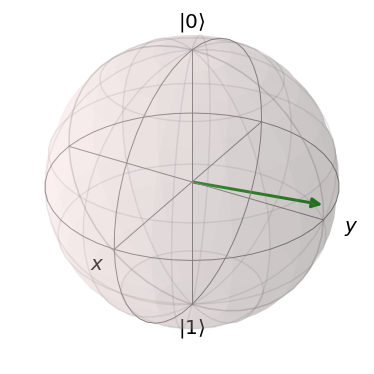

In [32]:
real_state = qt.Qobj(real_circuit(real_params).numpy())
(real_state*real_state).tr()
b = qt.Bloch()

b.add_states(real_state)
b.render()

In [33]:
N = 100     #Number of training cycles
steps = 1 #Number of steps for generator training
ratio = 10  #gen/disc training ratio


#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity
States = []

#-------------------------------------------

for i in range (200):
    
    #training discriminator
    gen_weights_non_grad = torch.tensor(gen_weights_grad.detach().numpy(), requires_grad = False)
    opt = optim.OAdam([disc_weights_grad, gen_weights_non_grad], lr = 0.05)
    
    def closure():
        opt.zero_grad()
        
        loss = disc_cost(disc_weights_grad, gen_weights_non_grad)
        
        disc_weights=np.array( list(disc_weights_grad.detach().numpy()) ,    requires_grad=True )
        gen_weights =np.array( list(gen_weights_non_grad.detach().numpy()) , requires_grad=False)
        
        grad_gen_circuit_disc =qml.grad(gen_disc_circuit_grad,  argnum=1)
        grad_real_disc_circuit=qml.grad(real_disc_circuit_grad, argnum=1) 
        grad_fn_disc= grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(real_params, disc_weights)

        disc_weights_grad.grad = torch.tensor(grad_fn_disc)

        return loss

    for j in range(steps*ratio):
        opt.step(closure)
            
        if j == steps*ratio -1:
            costD_val = disc_cost(disc_weights_grad, gen_weights_non_grad)
            Disc_cost += [-costD_val.detach().numpy()] # P(R|R)-P(R|G)

    
    #training generator
    disc_weights_non_grad = torch.tensor(disc_weights_grad.detach().numpy(), requires_grad = False)
    opt = optim.OAdam([disc_weights_non_grad, gen_weights_grad], lr = 0.05)

    def closure():
        opt.zero_grad()
        loss = gen_cost(gen_weights_non_grad, disc_weights_grad)
        
        disc_weights=np.array( list(disc_weights_grad.detach().numpy()) ,    requires_grad=False)
        gen_weights =np.array( list(gen_weights_non_grad.detach().numpy()) , requires_grad=True)
        
        grad_fn_gen=-qml.grad(gen_disc_circuit_grad, argnum=0)(gen_weights, disc_weights)
        
        gen_weights_grad.grad = torch.tensor(grad_fn_gen)

        return loss

    for j in range(steps):
        opt.step(closure)
        
        if j == steps-1:
            costG_val = gen_cost(gen_weights_grad, disc_weights_non_grad)
            Gen_cost += [-costG_val.detach().numpy()] # P(R|G)
    
 

    F_Tr_st = F_Tr_state(real_params,gen_weights_grad)
    
    
    F += [F_Tr_st[0]] #Fidelity
    Trace_d += [F_Tr_st[1]] #Trace distance
    States += [F_Tr_st[3]]
    
    print("P(R|R)-P(R|G): ", -costD_val)
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",F_Tr_st[0])
    print("Trace distance: ",F_Tr_st[1])
    print("------------------------------")

P(R|R)-P(R|G):  tensor(0.4771, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.4972, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.8075058764463589
Trace distance:  0.470834212299997
------------------------------
P(R|R)-P(R|G):  tensor(0.4708, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.5139, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.8180454576731305
Trace distance:  0.46102128968168343
------------------------------
P(R|R)-P(R|G):  tensor(0.4609, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.5083, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.8165026403970914
Trace distance:  0.455055067626307
------------------------------
P(R|R)-P(R|G):  tensor(0.4550, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.5422, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.8328879358533772
Trace distance:  0.4336340158022024
------------------------------
P(R|R)-P(R|G):  tensor(0.4335, dt

P(R|R)-P(R|G):  tensor(0.0559, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.4622, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9983143522153016
Trace distance:  0.022236468729863033
------------------------------
P(R|R)-P(R|G):  tensor(0.0203, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.9329, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9981249199137558
Trace distance:  0.06086438576450566
------------------------------
P(R|R)-P(R|G):  tensor(0.0560, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.4528, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9983143632477582
Trace distance:  0.0222364138737925
------------------------------
P(R|R)-P(R|G):  tensor(0.0209, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.8593, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9982570574479515
Trace distance:  0.05865730009911466
------------------------------
P(R|R)-P(R|G):  tensor(0.053

P(R|R)-P(R|G):  tensor(0.0570, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.5028, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9983114447797469
Trace distance:  0.022252485875536347
------------------------------
P(R|R)-P(R|G):  tensor(0.0209, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.8565, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9981247411162105
Trace distance:  0.06086204867008317
------------------------------
P(R|R)-P(R|G):  tensor(0.0582, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.4714, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9983114574386682
Trace distance:  0.022252409368249508
------------------------------
P(R|R)-P(R|G):  tensor(0.0211, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.8693, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9981247462707425
Trace distance:  0.06086198708998041
------------------------------
P(R|R)-P(R|G):  tensor(0.0

P(R|R)-P(R|G):  tensor(0.0567, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.5115, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.998311828985926
Trace distance:  0.022251140710558046
------------------------------
P(R|R)-P(R|G):  tensor(0.0216, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.8946, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9982573527177709
Trace distance:  0.058647548493103385
------------------------------
P(R|R)-P(R|G):  tensor(0.0545, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.4715, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9983118441764796
Trace distance:  0.022251058131337948
------------------------------
P(R|R)-P(R|G):  tensor(0.0212, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.8753, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9982573561725053
Trace distance:  0.05864751796967801
------------------------------
P(R|R)-P(R|G):  tensor(0.0

P(R|R)-P(R|G):  tensor(0.0555, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.7214, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9989876194799886
Trace distance:  0.01608867843028934
------------------------------
P(R|R)-P(R|G):  tensor(0.0141, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.2866, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.998124035812665
Trace distance:  0.060874671030374666
------------------------------
P(R|R)-P(R|G):  tensor(0.0544, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.7062, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9989876198064735
Trace distance:  0.016088671434940024
------------------------------
P(R|R)-P(R|G):  tensor(0.0143, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.3348, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9981240379354165
Trace distance:  0.0608746373464663
------------------------------
P(R|R)-P(R|G):  tensor(0.054

P(R|R)-P(R|G):  tensor(0.0545, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.3866, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9983121121004833
Trace distance:  0.022249574738210917
------------------------------
P(R|R)-P(R|G):  tensor(0.0201, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.8595, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.9982574108903491
Trace distance:  0.05864709044248017
------------------------------
P(R|R)-P(R|G):  tensor(0.0544, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.4049, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.998312117599264
Trace distance:  0.022249545842143968
------------------------------
P(R|R)-P(R|G):  tensor(0.0204, dtype=torch.float64, grad_fn=<NegBackward0>)
P(R|G):  tensor(0.8337, dtype=torch.float64, grad_fn=<NegBackward0>)
Fidelity:  0.998257413540129
Trace distance:  0.05864705532877458
------------------------------
P(R|R)-P(R|G):  tensor(0.053

Comparing output for |0> and printing tthe rotation params of the generator:

In [34]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

In [35]:
from matplotlib import pyplot as plt

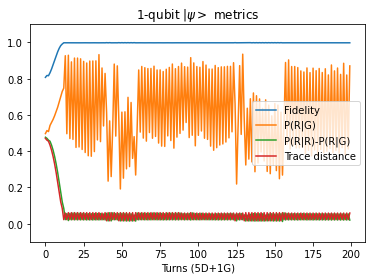

In [36]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([-0.1,1.1])
plt.xlabel('Turns (5D+1G)') 
plt.title("1-qubit $|\psi>$ metrics")
plt.legend()
plt.savefig('1qubitlearning_parameter_shift.png', format='png')

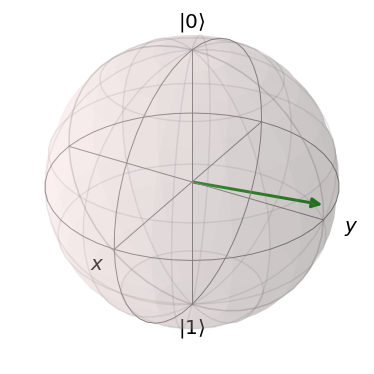

In [51]:
real_state = qt.Qobj(real_circuit(real_params).numpy())
(real_state*real_state).tr()

b = qt.Bloch()

b.add_states(real_state)
b.render()

In [44]:
(real_state*real_state).tr()

0.9627089324056379

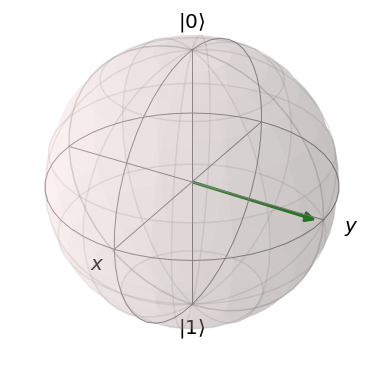

In [45]:
gen_state = qt.Qobj(gen_circuit(gen_weights_grad.detach().numpy()).numpy())
(gen_state*gen_state).tr()

b = qt.Bloch()

b.add_states(gen_state)
b.render()

In [46]:
(gen_state*gen_state).tr()

0.9590568412848506

In [50]:
print(len(States))

200


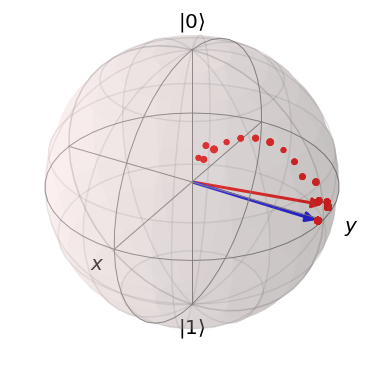

In [48]:
b = qt.Bloch()
b.point_marker=['o']
b.point_color=['r']
b.vector_color=['r', 'b']
final_real = F_Tr_state(real_params,gen_weights_grad)[2]
final_gen =  F_Tr_state(real_params,gen_weights_grad)[3]
b.add_states(final_real)
b.add_states(final_gen)
b.add_states(States, 'point')
b.render()
plt.savefig('blochsphere.png', format='png')